# Decision Transformer for Iterated Prisoner's Dilemma

This notebook demonstrates a Decision-Transformer agent trained to play
the Iterated Prisoner's Dilemma (IPD). The model imitates behaviour from
trajectories rather than learning online.

**Unified Parameters**: This demo uses the standardized parameters
from the comparative study: 100 rounds per game, 20 matches per opponent,
and the complete set of 7 opponent strategies.

In [ ]:
import os
import sys
import time
import random
import pickle
import argparse
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

In [ ]:
# Parse command line arguments with unified parameters
parser = argparse.ArgumentParser(description="Demo of Decision Transformer for Iterated Prisoner's Dilemma")
parser.add_argument("--num_rounds", type=int, default=100,
                    help="Number of rounds per episode (unified parameter: 100)")
parser.add_argument("--num_matches", type=int, default=20,
                    help="Number of matches per opponent for evaluation (unified parameter: 20)")
parser.add_argument("--seed", type=int, default=42,
                    help="Random seed (unified parameter: 42)")

# Handle running in Jupyter vs as script
try:
    # When running as a script
    args = parser.parse_args()
except SystemExit:
    # When running in Jupyter (no command line args)
    args = parser.parse_args([])

usage: ipykernel_launcher.py [-h] [--num_rounds NUM_ROUNDS]
                             [--num_matches NUM_MATCHES] [--seed SEED]
ipykernel_launcher.py: error: unrecognized arguments: --f=/Users/alex/Library/Jupyter/runtime/kernel-v37fd0d2aec2cfdd6c1b0030ae0d005a61dc5a1273.json


In [ ]:
# Locate repo root in both .py (jupytext) and .ipynb contexts
try:                         # executed as .py file
    repo_root = Path(__file__).resolve().parents[1]
except NameError:            # executed in a Jupyter kernel
    repo_root = Path.cwd().resolve()
    if repo_root.name == "notebooks":
        repo_root = repo_root.parent

sys.path.append(str(repo_root))

# Import strategies directly to avoid gymnasium dependency
sys.path.append(str(repo_root / "env"))
from strategies import (
    TitForTat,
    AlwaysCooperate,
    AlwaysDefect,
    RandomStrategy,
    PavlovStrategy,
    GrudgerStrategy,
    GTFTStrategy,
)

# Import IPDEnv and simulate_match only when needed
def get_ipd_env():
    """Lazy import of IPDEnv to avoid gymnasium dependency during import"""
    from env import IPDEnv, simulate_match
    return IPDEnv, simulate_match

# Paths
models_dir = repo_root / "models"
results_dir = repo_root / "results" / "transformer"
comparison_dir = repo_root / "comparison_results"

# Helper: PNG + CSV saver
def save_plot_and_csv(x, y, name: str, folder: str = "results"):
    """Save PNG and matching CSV so numbers stay inspectable."""
    import pandas as pd
    import matplotlib.pyplot as plt

    os.makedirs(folder, exist_ok=True)
    pd.DataFrame({"x": x, "y": y}).to_csv(f"{folder}/{name}_data.csv", index=False)
    plt.figure()
    plt.plot(x, y)
    plt.title(name.replace("_", " ").title())
    plt.savefig(f"{folder}/{name}.png", dpi=120, bbox_inches="tight")
    plt.close()

## Decision-Transformer architecture

In [ ]:
class SavedEfficientDecisionTransformer(torch.nn.Module):
    """Efficient transformer matching the exact architecture of saved model"""
    
    def __init__(
        self,
        action_dim: int = 2,
        hidden_size: int = 32,
        max_rtg: float = 100.0,
        n_heads: int = 4,
        n_layers: int = 3,
        dropout: float = 0.1,
        context_length: int = 15,
        ffn_dim: int = 256,
        strategy_head_1: int = 64
    ):
        super().__init__()
        self.context_length = context_length
        self.hidden_size = hidden_size
        self.max_rtg = max_rtg
        
        # Separate embeddings for player and opponent actions (32 dim each)
        self.player_action_embedding = torch.nn.Embedding(action_dim, hidden_size)
        self.opponent_action_embedding = torch.nn.Embedding(action_dim, hidden_size)
        
        # RTG embedding (32 output, bias=True)
        self.rtg_embedding = torch.nn.Linear(1, hidden_size, bias=True)
        
        # Strategic features (3 -> 32)
        self.strategic_features = torch.nn.Linear(3, hidden_size)
        
        # Positional embedding (15 x 128)
        self.position_embedding = torch.nn.Embedding(context_length, 128)  # Note: 128, not hidden_size!
        
        # Input layer norm (128)
        self.embed_ln = torch.nn.LayerNorm(128)
        
        # Transformer layers with specific FFN dim
        self.transformer_layers = torch.nn.ModuleList([
            torch.nn.TransformerEncoderLayer(
                d_model=128,  # Note: 128, not hidden_size!
                nhead=n_heads,
                dim_feedforward=ffn_dim,  # 256
                dropout=dropout,
                activation='gelu',
                batch_first=True,
                norm_first=True
            )
            for _ in range(n_layers)
        ])
        
        # Strategy prediction head with exact saved dimensions
        self.strategy_head = torch.nn.Sequential(
            torch.nn.Linear(128, strategy_head_1),  # 128 -> 64
            torch.nn.GELU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(strategy_head_1, strategy_head_1 // 2),  # 64 -> 32
            torch.nn.GELU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(strategy_head_1 // 2, action_dim)  # 32 -> 2
        )
    
    def forward(self, player_actions, opponent_actions, returns_to_go, strategic_features):
        B, L = player_actions.shape
        
        # Normalize RTG
        rtg_norm = (returns_to_go.unsqueeze(-1) / self.max_rtg).clamp(0, 1)
        
        # Get embeddings (all 32-dim)
        player_embed = self.player_action_embedding(player_actions)
        opponent_embed = self.opponent_action_embedding(opponent_actions)
        rtg_embed = self.rtg_embedding(rtg_norm)
        strategic_embed = self.strategic_features(strategic_features).unsqueeze(1).expand(-1, L, -1)
        
        # Combine embeddings (32 + 32 + 32 + 32 = 128)
        token_embed = torch.cat([player_embed, opponent_embed, rtg_embed, strategic_embed], dim=-1)
        
        # Add positional encoding (128-dim)
        positions = torch.arange(L, device=player_actions.device).unsqueeze(0).expand(B, -1)
        token_embed = token_embed + self.position_embedding(positions)
        
        # Layer norm
        x = self.embed_ln(token_embed)
        
        # Transformer layers
        for layer in self.transformer_layers:
            x = layer(x)
        
        # Strategy prediction
        strategy_logits = self.strategy_head(x)
        
        return strategy_logits


class EfficientDecisionTransformer(torch.nn.Module):
    """Efficient transformer for strategic IPD learning with opponent modeling"""
    
    def __init__(
        self,
        action_dim: int = 2,
        hidden_size: int = 32,
        max_rtg: float = 100.0,
        n_heads: int = 4,
        n_layers: int = 3,
        dropout: float = 0.1,
        context_length: int = 15
    ):
        super().__init__()
        self.context_length = context_length
        self.hidden_size = hidden_size
        self.max_rtg = max_rtg
        
        # Separate embeddings for player and opponent actions
        self.player_action_embedding = torch.nn.Embedding(action_dim, hidden_size)
        self.opponent_action_embedding = torch.nn.Embedding(action_dim, hidden_size)
        
        # RTG embedding (normalized to 0-1 range)
        self.rtg_embedding = torch.nn.Linear(1, hidden_size, bias=True)
        
        # Strategic features (cooperation rates, trends)
        self.strategic_features = torch.nn.Linear(3, hidden_size)
        
        # Positional embedding
        self.position_embedding = torch.nn.Embedding(context_length, hidden_size)
        
        # Input layer norm
        self.embed_ln = torch.nn.LayerNorm(hidden_size)
        
        # Transformer layers
        self.transformer_layers = torch.nn.ModuleList([
            torch.nn.TransformerEncoderLayer(
                d_model=hidden_size,
                nhead=n_heads,
                dim_feedforward=hidden_size * 4,
                dropout=dropout,
                activation='gelu',
                batch_first=True,
                norm_first=True
            )
            for _ in range(n_layers)
        ])
        
        # Strategy prediction head (3 layers for better learning)
        self.strategy_head = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.GELU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_size, hidden_size // 2),
            torch.nn.GELU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_size // 2, action_dim)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights with smaller values for stability"""
        for module in self.modules():
            if isinstance(module, torch.nn.Linear):
                torch.nn.init.normal_(module.weight, std=0.02)
                if module.bias is not None:
                    torch.nn.init.zeros_(module.bias)
            elif isinstance(module, torch.nn.Embedding):
                torch.nn.init.normal_(module.weight, std=0.02)
    
    def forward(self, player_actions, opponent_actions, returns_to_go, strategic_features):
        B, L = player_actions.shape
        
        # Normalize RTG
        rtg_norm = (returns_to_go.unsqueeze(-1) / self.max_rtg).clamp(0, 1)
        
        # Get embeddings
        player_embed = self.player_action_embedding(player_actions)
        opponent_embed = self.opponent_action_embedding(opponent_actions)
        rtg_embed = self.rtg_embedding(rtg_norm)
        strategic_embed = self.strategic_features(strategic_features).unsqueeze(1).expand(-1, L, -1)
        
        # Combine embeddings
        token_embed = player_embed + opponent_embed + rtg_embed + strategic_embed
        
        # Add positional encoding
        positions = torch.arange(L, device=player_actions.device).unsqueeze(0).expand(B, -1)
        token_embed = token_embed + self.position_embedding(positions)
        
        # Layer norm
        x = self.embed_ln(token_embed)
        
        # Transformer layers
        for layer in self.transformer_layers:
            x = layer(x)
        
        # Strategy prediction
        strategy_logits = self.strategy_head(x)
        
        return strategy_logits


# Legacy DecisionTransformer for fallback
class DecisionTransformer(torch.nn.Module):
    """Causal transformer that predicts the next action given (RTG, state, action) context."""

    def __init__(
        self,
        state_dim=3,         # -1 / 0 / 1   (no-action, C, D)
        action_dim=2,        # 0 / 1        (C, D)
        hidden_size=128,
        max_rtg=50.0,
        n_heads=4,
        n_layers=3,
        dropout=0.1,
        context_length=5,
    ):
        super().__init__()
        self.context_length = context_length
        self.max_rtg = max_rtg

        # Token embeddings
        self.state_embedding = torch.nn.Embedding(state_dim, hidden_size)
        self.action_embedding = torch.nn.Embedding(action_dim + 1, hidden_size)  # +1 for padding/-1
        self.rtg_embedding = torch.nn.Linear(1, hidden_size) 

        # Positional & token-type embeddings
        self.position_embedding = torch.nn.Embedding(context_length, hidden_size)
        self.token_type_embedding = torch.nn.Embedding(3, hidden_size)  # 0=rtg 1=state 2=action

        # Transformer encoder
        enc_layer = torch.nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=n_heads,
            dim_feedforward=hidden_size * 4,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
        )
        self.transformer = torch.nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        # Action head
        self.action_head = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, action_dim),
        )

    def forward(self, states, actions, rtgs, attn_mask=None):
        B, L = states.shape

        pos_ids = torch.arange(L, device=states.device).unsqueeze(0).repeat(B, 1)

        # normalise RTG
        rtgs = (rtgs.unsqueeze(-1) / self.max_rtg).clamp(0, 1)

        s_idx = (states + 1).clamp(0)        # -1→0, 0→1, 1→2
        a_idx = (actions + 1).clamp(0)

        rtg_tok    = self.rtg_embedding(rtgs)
        state_tok  = self.state_embedding(s_idx)
        action_tok = self.action_embedding(a_idx)

        # + positional / token-type
        rtg_tok    += self.position_embedding(pos_ids) + self.token_type_embedding(torch.zeros_like(states))
        state_tok  += self.position_embedding(pos_ids) + self.token_type_embedding(torch.ones_like(states))
        action_tok += self.position_embedding(pos_ids) + self.token_type_embedding(2 * torch.ones_like(states))

        seq = torch.cat([rtg_tok, state_tok, action_tok], dim=1)  # shape B × 3L × H

        if attn_mask is not None:
            attn_mask = attn_mask.repeat(1, 3)  # expand to sequence length
        h = self.transformer(seq, src_key_padding_mask=attn_mask)

        action_h = h[:, 2::3, :]  # every third token (action positions)
        logits = self.action_head(action_h)
        return logits


class EfficientTransformerStrategy:
    """Strategy wrapper for EfficientDecisionTransformer"""
    
    def __init__(self, model, device="cpu"):
        self.name = "EfficientTransformerAgent"
        self.model = model.to(device).eval()
        self.device = device
        self.context_length = model.context_length
        self.target_return = 50.0
    
    def action(self, history, player_idx=0):
        if not history:
            return 0  # cooperate first
        
        # Extract actions and calculate rewards
        player_actions = []
        opponent_actions = []
        rewards = []
        
        for p_act, o_act in [(h[player_idx], h[1 - player_idx]) for h in history]:
            player_actions.append(p_act)
            opponent_actions.append(o_act)
            
            # IPD payoff matrix
            if p_act == 0 and o_act == 0:  # CC
                reward = 3
            elif p_act == 0 and o_act == 1:  # CD
                reward = 0
            elif p_act == 1 and o_act == 0:  # DC
                reward = 5
            else:  # DD
                reward = 1
            
            rewards.append(reward)
        
        # Calculate returns-to-go
        rtgs = []
        rtg = self.target_return - sum(rewards)
        for i in range(len(rewards)):
            rtgs.append(rtg / max(1, len(rewards) - i))
        
        # Calculate strategic features
        if len(opponent_actions) > 0:
            opp_coop_rate = sum(1-a for a in opponent_actions) / len(opponent_actions)
            my_coop_rate = sum(1-a for a in player_actions) / len(player_actions)
            
            # Recent trend (last 5 actions or all if less)
            recent_opp = opponent_actions[-5:] if len(opponent_actions) >= 5 else opponent_actions
            recent_trend = sum(1-a for a in recent_opp) / len(recent_opp)
        else:
            opp_coop_rate = my_coop_rate = recent_trend = 0.5
        
        # Truncate to context length
        L = min(len(player_actions), self.context_length)
        player_actions_tensor = torch.tensor(player_actions[-L:], dtype=torch.long, device=self.device).unsqueeze(0)
        opponent_actions_tensor = torch.tensor(opponent_actions[-L:], dtype=torch.long, device=self.device).unsqueeze(0)
        rtgs_tensor = torch.tensor(rtgs[-L:], dtype=torch.float, device=self.device).unsqueeze(0)
        strategic_tensor = torch.tensor([opp_coop_rate, my_coop_rate, recent_trend], 
                                      dtype=torch.float, device=self.device).unsqueeze(0)
        
        with torch.no_grad():
            logits = self.model(player_actions_tensor, opponent_actions_tensor, rtgs_tensor, strategic_tensor)
            probs = torch.softmax(logits[0, -1], dim=-1)
            return torch.multinomial(probs, 1).item()


class TransformerStrategy:
    """Wrapper that exposes `.action(history)` for simulate_match."""

    def __init__(self, model, model_params, device="cpu"):
        self.name = "TransformerAgent"
        self.model = model.to(device).eval()
        self.device = device
        self.context_len = model_params["context_length"]
        self.target_return = 30.0  # heuristic RTG

    def action(self, history, player_idx=0):
        if not history:
            return 0  # cooperate first

        states, actions, rewards = [], [], []

        for p_act, o_act in [(h[player_idx], h[1 - player_idx]) for h in history]:
            # PD payoff
            rewards.append((3, 0, 5, 1)[p_act * 2 + o_act])  # quick map
            states.append(o_act)
            actions.append(p_act)

        rtg = self.target_return - sum(rewards)
        rtgs = [rtg / max(1, len(history) - i) for i in range(len(history))]

        # Pad/truncate to context length
        L = min(len(states), self.context_len)
        
        states_tensor = torch.tensor(states[-L:], dtype=torch.long, device=self.device).unsqueeze(0)
        actions_tensor = torch.tensor(actions[-L:], dtype=torch.long, device=self.device).unsqueeze(0)
        rtgs_tensor = torch.tensor(rtgs[-L:], dtype=torch.float, device=self.device).unsqueeze(0)

        with torch.no_grad():
            logits = self.model(states_tensor, actions_tensor, rtgs_tensor)
            probs = torch.softmax(logits[0, -1], dim=-1)
            return torch.multinomial(probs, 1).item()

## Loading the Trained Transformer

We load the transformer model from the unified training process.
If the model doesn't exist and `QUICK_DEMO=1` is set, we can quickly
train a demo model for illustration purposes.

In [ ]:
def quick_train_transformer(save_dir=models_dir, num_epochs=2, seed=args.seed, num_rounds=args.num_rounds):
    """Quickly train a transformer for demo purposes."""
    print("Training a quick demo transformer...")
    
    # Set seeds
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Model parameters
    model_params = {
        "state_dim": 3,
        "action_dim": 2,
        "hidden_size": 64,
        "max_rtg": 50.0,
        "n_heads": 2,
        "n_layers": 2,
        "dropout": 0.1,
        "context_length": 5,
    }
    
    # Create model
    model = DecisionTransformer(**model_params)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    
    # Generate training data quickly
    print("Generating training data...")
    
    # Get IPDEnv with lazy import
    IPDEnv, simulate_match = get_ipd_env()
    
    # Complete set of opponent strategies from the comparative study
    opponents = [
        TitForTat(),
        AlwaysCooperate(),
        AlwaysDefect(),
        RandomStrategy(coop_prob=0.5, seed=seed),
        PavlovStrategy(),
        GrudgerStrategy(),
        GTFTStrategy(forgiveness_prob=0.1, seed=seed+100),
    ]
    
    trajectories = []
    env = IPDEnv(num_rounds=num_rounds, seed=seed)
    
    # Generate some trajectories with a simple cooperative strategy
    for opponent in opponents[:3]:  # Quick demo - only first 3 opponents
        for _ in range(5):  # 5 games per opponent
            results = simulate_match(env, AlwaysCooperate(), opponent, num_rounds)
            
            # Extract actions from history
            player_actions = [step['player_action'] for step in results['history']]
            opponent_actions = [step['opponent_action'] for step in results['history']]
            
            states = [0]  # Start with no previous action
            actions = player_actions
            rewards = []
            
            for i, (p_act, o_act) in enumerate(zip(player_actions, opponent_actions)):
                reward = (3, 0, 5, 1)[p_act * 2 + o_act]
                rewards.append(reward)
                if i < len(actions) - 1:
                    states.append(opponent_actions[i])
            
            trajectories.append({
                'states': states,
                'actions': actions,
                'rewards': rewards
            })
    
    # Simple dataset
    class SimpleDataset(torch.utils.data.Dataset):
        def __init__(self, trajectories, context_length=5):
            self.trajectories = trajectories
            self.context_length = context_length
            self.data = []
            
            for traj in trajectories:
                states = traj['states']
                actions = traj['actions']
                rewards = traj['rewards']
                
                # Create RTG
                rtgs = []
                for i in range(len(rewards)):
                    rtg = sum(rewards[i:])
                    rtgs.append(rtg)
                
                # Create training samples
                for i in range(1, len(states)):
                    start_idx = max(0, i - context_length + 1)
                    
                    sample_states = states[start_idx:i+1]
                    sample_actions = actions[start_idx:i+1]
                    sample_rtgs = rtgs[start_idx:i+1]
                    
                    # Pad if necessary
                    while len(sample_states) < context_length:
                        sample_states = [-1] + sample_states
                        sample_actions = [-1] + sample_actions
                        sample_rtgs = [0.0] + sample_rtgs
                    
                    # Target is the next action
                    target_action = actions[i] if i < len(actions) else 0
                    
                    self.data.append({
                        'states': torch.tensor(sample_states, dtype=torch.long),
                        'actions': torch.tensor(sample_actions, dtype=torch.long),
                        'rtgs': torch.tensor(sample_rtgs, dtype=torch.float),
                        'target': torch.tensor(target_action, dtype=torch.long)
                    })
        
        def __len__(self):
            return len(self.data)
        
        def __getitem__(self, idx):
            return self.data[idx]
    
    # Create dataset and dataloader
    dataset = SimpleDataset(trajectories, model_params["context_length"])
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)
    
    # Training
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    
    print(f"Training for {num_epochs} epochs...")
    start_time = time.time()
    
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in dataloader:
            states = batch['states'].to(device)
            actions = batch['actions'].to(device)
            rtgs = batch['rtgs'].to(device)
            targets = batch['target'].to(device)
            
            optimizer.zero_grad()
            logits = model(states, actions, rtgs)
            loss = criterion(logits[:, -1], targets)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}: Loss = {total_loss/len(dataloader):.4f}")
    
    print(f"Quick training completed in {time.time() - start_time:.1f}s")
    
    # Save model
    os.makedirs(save_dir, exist_ok=True)
    model_path = save_dir / "transformer_quick_demo.pth"
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_params': model_params
    }, model_path)
    
    return model, model_params, model_path

# Try to load the unified transformer model
model_path = models_dir / "transformer_best.pth"
quick_demo = False

# First try to load the real trained model
if not model_path.exists():
    alternatives = list(models_dir.glob("transformer*.pth"))
    if alternatives:
        model_path = alternatives[0]
    else:
        model_path = None

if model_path and model_path.exists():
    print(f"Loading transformer model from {model_path.name}")
    try:
        checkpoint = torch.load(model_path, map_location="cpu")
        
        # Check if this is the EfficientDecisionTransformer (look for key patterns)
        checkpoint_keys = list(checkpoint.keys())
        is_efficient_model = any('player_action_embedding' in key for key in checkpoint_keys)
        
        if is_efficient_model:
            # Load EfficientDecisionTransformer with parameters from the checkpoint
            print("Detected EfficientDecisionTransformer format")
            
            # Infer exact parameters from saved model tensors
            action_embed_size = checkpoint['player_action_embedding.weight'].shape[1]  # hidden_size = 32
            context_length = checkpoint['position_embedding.weight'].shape[0]  # 15
            ffn_size = checkpoint['transformer_layers.0.linear1.weight'].shape[0]  # 256
            strategy_head_1 = checkpoint['strategy_head.0.weight'].shape[0]  # 64
            
            # Model was saved with these specific parameters
            model_params = {
                "action_dim": 2,
                "hidden_size": action_embed_size,  # 32
                "max_rtg": 100.0,
                "n_heads": 4,
                "n_layers": 3,
                "dropout": 0.1,
                "context_length": context_length,  # 15
                "ffn_dim": ffn_size,  # 256 (for custom ffn size)
                "strategy_head_1": strategy_head_1  # 64
            }
            
            # Create model with custom architecture matching saved model
            model = SavedEfficientDecisionTransformer(**model_params)
            model.load_state_dict(checkpoint)
            print(f"Loaded EfficientDecisionTransformer with hidden_size={action_embed_size}, context_length={context_length}")
            
        else:
            # Fallback to legacy DecisionTransformer
            print("Detected legacy DecisionTransformer format")
            model_params = {
                "state_dim": 3, "action_dim": 2, "hidden_size": 128, "max_rtg": 50.0,
                "n_heads": 4, "n_layers": 3, "dropout": 0.1, "context_length": 5
            }
            model = DecisionTransformer(**model_params)
            model.load_state_dict(checkpoint)
            
    except Exception as e:
        print(f"Failed to load model: {e}")
        print("Switching to quick demo mode...")
        quick_demo = True
        model, model_params, model_path = quick_train_transformer()
else:
    # Force quick demo if no model found
    if os.environ.get("QUICK_DEMO") == "1":
        print("QUICK_DEMO mode forced")
    else:
        print("No transformer model found")
    quick_demo = True
    model, model_params, model_path = quick_train_transformer()

# Create strategy wrapper based on model type
device = "cuda" if torch.cuda.is_available() else "cpu"

if not quick_demo and isinstance(model, (EfficientDecisionTransformer, SavedEfficientDecisionTransformer)):
    transformer_strategy = EfficientTransformerStrategy(model, device)
elif not quick_demo:
    transformer_strategy = TransformerStrategy(model, model_params, device)
else:
    # Quick demo uses legacy format
    transformer_strategy = TransformerStrategy(model, model_params, device)

print(f"Loaded transformer with {sum(p.numel() for p in model.parameters())} parameters")

Loading transformer model from transformer_best.pth
Detected EfficientDecisionTransformer format
Loaded EfficientDecisionTransformer with hidden_size=32, context_length=15
Loaded transformer with 410338 parameters


## Evaluating Against All Opponent Strategies

We evaluate the transformer strategy against all 7 opponent strategies used in the
comparative study: TitForTat, AlwaysCooperate, AlwaysDefect, Random(p=0.5),
Pavlov, Grudger, and GTFT(p=0.1).

In [ ]:
def play_match(strategy, opponent, num_rounds=args.num_rounds, seed=args.seed):
    """Play a single match between strategy and opponent."""
    IPDEnv, simulate_match = get_ipd_env()
    env = IPDEnv(num_rounds=num_rounds, seed=seed)
    
    # Reset random states
    if hasattr(opponent, 'rng'):
        opponent.rng = np.random.RandomState(seed + 1)
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    results = simulate_match(env, strategy, opponent, num_rounds)
    
    # Get cooperation rates from results
    player_coop = results['cooperation_rate_player']
    opponent_coop = results['cooperation_rate_opponent']
    
    return results['player_score'], player_coop, opponent_coop

# Complete set of opponent strategies from the comparative study
opponents = {
    "TitForTat": TitForTat(),
    "AlwaysCooperate": AlwaysCooperate(),
    "AlwaysDefect": AlwaysDefect(),
    "Random(p=0.5)": RandomStrategy(coop_prob=0.5, seed=args.seed),
    "Pavlov": PavlovStrategy(),
    "Grudger": GrudgerStrategy(),
    "GTFT(p=0.1)": GTFTStrategy(forgiveness_prob=0.1, seed=args.seed+100),
}

# Evaluate against all opponents
stats = {}
print("Evaluating transformer strategy against all opponent strategies...")

for name, opponent in opponents.items():
    print(f"  vs {name}...")
    scores, player_coop_rates, opponent_coop_rates = [], [], []
    
    for i in range(args.num_matches):
        score, p_coop, o_coop = play_match(transformer_strategy, opponent, seed=args.seed + i)
        scores.append(score)
        player_coop_rates.append(p_coop)
        opponent_coop_rates.append(o_coop)
    
    stats[name] = {
        "avg_score": np.mean(scores),
        "std_score": np.std(scores),
        "player_coop": np.mean(player_coop_rates),
        "opponent_coop": np.mean(opponent_coop_rates),
    }

Evaluating transformer strategy against all opponent strategies...
  vs TitForTat...
  vs AlwaysCooperate...
  vs AlwaysDefect...
  vs Random(p=0.5)...
  vs Pavlov...
  vs Grudger...
  vs GTFT(p=0.1)...


## Results Visualization and Comparison

Let's visualize the transformer's performance and compare it with results
from the comprehensive comparative study.

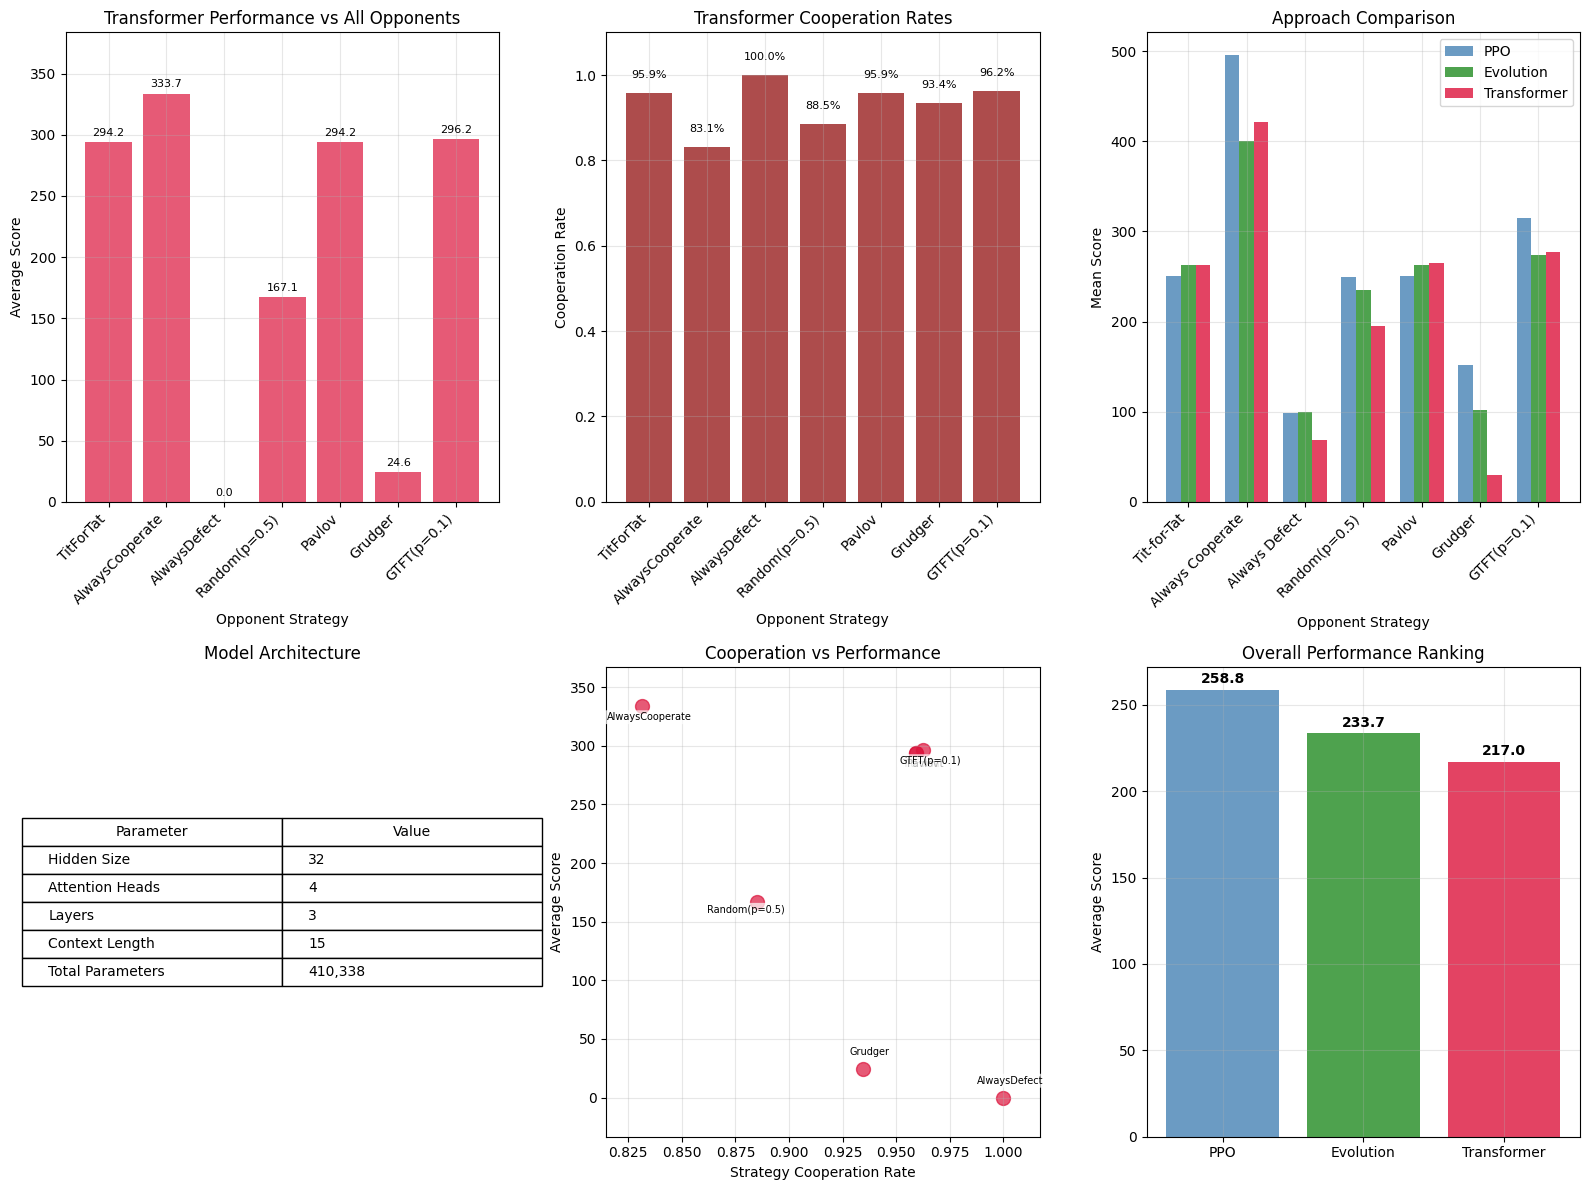

In [ ]:
# Create visualizations
names = list(stats.keys())
avg_scores = [stats[n]["avg_score"] for n in names]
player_coop = [stats[n]["player_coop"] for n in names]
opponent_coop = [stats[n]["opponent_coop"] for n in names]

# Save current results
os.makedirs(results_dir, exist_ok=True)
current_results = pd.DataFrame({
    'Opponent': names,
    'Mean_Score': avg_scores,
    'Std_Score': [stats[n]["std_score"] for n in names],
    'Player_Cooperation': player_coop,
    'Opponent_Cooperation': opponent_coop
})
current_results.to_csv(results_dir / "current_evaluation.csv", index=False)

# Load comparison results if available
comparison_available = False
if (comparison_dir / "comprehensive_results.csv").exists():
    comparison_df = pd.read_csv(comparison_dir / "comprehensive_results.csv")
    ppo_comparison = comparison_df[comparison_df['Approach'] == 'PPO']
    evolution_comparison = comparison_df[comparison_df['Approach'] == 'EVOLUTION']
    transformer_comparison = comparison_df[comparison_df['Approach'] == 'TRANSFORMER']
    comparison_available = True

# Create comprehensive visualization
plt.figure(figsize=(16, 12))

# 1. Performance comparison
plt.subplot(2, 3, 1)
bars = plt.bar(range(len(names)), avg_scores, color='crimson', alpha=0.7)
plt.xlabel("Opponent Strategy")
plt.ylabel("Average Score")
plt.title("Transformer Performance vs All Opponents")
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Add value labels on bars with better positioning
for bar, score in zip(bars, avg_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(avg_scores) * 0.01,
             f'{score:.1f}', ha='center', va='bottom', fontsize=8)

# Add some padding at the top
plt.ylim(0, max(avg_scores) * 1.15)

# 2. Cooperation rates
plt.subplot(2, 3, 2)
bars = plt.bar(range(len(names)), player_coop, color='darkred', alpha=0.7)
plt.xlabel("Opponent Strategy")
plt.ylabel("Cooperation Rate")
plt.title("Transformer Cooperation Rates")
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.ylim(0, 1.1)  # Extra space at top
plt.grid(True, alpha=0.3)

# Add percentage labels with better positioning
for bar, rate in zip(bars, player_coop):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.03,
             f'{rate:.1%}', ha='center', va='bottom', fontsize=8)

# 3. Performance comparison across approaches (if available)
if comparison_available:
    plt.subplot(2, 3, 3)
    
    # Prepare data for comparison
    comparison_names = []
    ppo_scores = []
    evolution_scores = []
    transformer_scores = []
    
    for _, row in transformer_comparison.iterrows():
        opponent = row['Opponent']
        comparison_names.append(opponent)
        transformer_scores.append(row['Mean_Score'])
        
        # Find corresponding scores from other approaches
        ppo_row = ppo_comparison[ppo_comparison['Opponent'] == opponent]
        evo_row = evolution_comparison[evolution_comparison['Opponent'] == opponent]
        
        ppo_scores.append(ppo_row['Mean_Score'].iloc[0] if len(ppo_row) > 0 else 0)
        evolution_scores.append(evo_row['Mean_Score'].iloc[0] if len(evo_row) > 0 else 0)
    
    x = np.arange(len(comparison_names))
    width = 0.25
    
    plt.bar(x - width, ppo_scores, width, label='PPO', color='steelblue', alpha=0.8)
    plt.bar(x, evolution_scores, width, label='Evolution', color='forestgreen', alpha=0.8)
    plt.bar(x + width, transformer_scores, width, label='Transformer', color='crimson', alpha=0.8)
    
    plt.xlabel("Opponent Strategy")
    plt.ylabel("Mean Score")
    plt.title("Approach Comparison")
    plt.xticks(x, comparison_names, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 4. Model architecture info
plt.subplot(2, 3, 4)
plt.axis('off')

arch_info = [
    ['Parameter', 'Value'],
    ['Hidden Size', str(model_params.get('hidden_size', 128))],
    ['Attention Heads', str(model_params.get('n_heads', 4))],
    ['Layers', str(model_params.get('n_layers', 3))],
    ['Context Length', str(model_params.get('context_length', 5))],
    ['Total Parameters', f"{sum(p.numel() for p in model.parameters()):,}"]
]

table = plt.table(cellText=arch_info[1:], colLabels=arch_info[0], cellLoc='left', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
plt.title("Model Architecture")

# 5. Strategy-specific analysis
plt.subplot(2, 3, 5)
cooperation_vs_score = [(stats[name]["player_coop"], stats[name]["avg_score"]) for name in names]
coop_rates, scores = zip(*cooperation_vs_score)

plt.scatter(coop_rates, scores, s=100, alpha=0.7, c='crimson')

# Improved annotation positioning to avoid overlap
for i, name in enumerate(names):
    # Smart positioning to avoid overlap
    x, y = coop_rates[i], scores[i]
    
    # Determine offset direction based on position
    if i < len(names) // 2:
        xytext = (8, 8)  # Upper right
    else:
        xytext = (-8, -8)  # Lower left
    
    # Special handling for extreme values
    if y > max(scores) * 0.8:  # High scores
        xytext = (5, -10)
    elif y < max(scores) * 0.3:  # Low scores
        xytext = (5, 10)
    
    plt.annotate(name, (x, y), 
                xytext=xytext, textcoords='offset points', 
                fontsize=7, ha='center',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, edgecolor='none'))

plt.xlabel("Strategy Cooperation Rate")
plt.ylabel("Average Score")
plt.title("Cooperation vs Performance")
plt.grid(True, alpha=0.3)
plt.margins(0.1)  # Add margins to prevent clipping

# 6. Overall ranking (if comparison available)
if comparison_available:
    plt.subplot(2, 3, 6)
    
    # Calculate overall averages
    overall_ppo = np.mean(ppo_scores)
    overall_evolution = np.mean(evolution_scores)
    overall_transformer = np.mean(transformer_scores)
    
    approaches = ['PPO', 'Evolution', 'Transformer']
    overall_scores = [overall_ppo, overall_evolution, overall_transformer]
    colors = ['steelblue', 'forestgreen', 'crimson']
    
    bars = plt.bar(approaches, overall_scores, color=colors, alpha=0.8)
    plt.ylabel("Average Score")
    plt.title("Overall Performance Ranking")
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, score in zip(bars, overall_scores):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 2,
                 f'{score:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(results_dir / "transformer_comprehensive_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

## Detailed Results Analysis

In [ ]:
print("="*60)
print("Transformer Strategy Performance Analysis")
print("="*60)

print(f"\nModel Architecture:")
print(f"  Hidden Size:      {model_params.get('hidden_size', 128)}")
print(f"  Attention Heads:  {model_params.get('n_heads', 4)}")
print(f"  Layers:           {model_params.get('n_layers', 3)}")
print(f"  Context Length:   {model_params.get('context_length', 5)}")
print(f"  Total Parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\nOverall Statistics:")
print(f"  Average Score: {np.mean(avg_scores):.2f}")
print(f"  Score Range: {np.min(avg_scores):.1f} - {np.max(avg_scores):.1f}")
print(f"  Score Std Dev: {np.std(avg_scores):.2f}")
print(f"  Average Cooperation: {np.mean(player_coop):.1%}")

print(f"\nPerformance vs Each Opponent:")
for name in names:
    score = stats[name]["avg_score"]
    coop = stats[name]["player_coop"]
    std = stats[name]["std_score"]
    print(f"  vs {name:<18}: Score {score:6.1f} ± {std:4.1f}, Cooperation {coop:5.1%}")

if comparison_available:
    print(f"\nComparison with Other Approaches:")
    print(f"  PPO Average:         {np.mean(ppo_scores):.2f}")
    print(f"  Evolution Average:   {np.mean(evolution_scores):.2f}")
    print(f"  Transformer Average: {np.mean(transformer_scores):.2f}")
    
    print(f"\nTransformer's Best Performances:")
    transformer_best = []
    for i, opponent in enumerate(comparison_names):
        transformer_score = transformer_scores[i]
        ppo_score = ppo_scores[i] 
        evo_score = evolution_scores[i]
        
        if transformer_score >= max(ppo_score, evo_score):
            advantage = transformer_score - max(ppo_score, evo_score)
            transformer_best.append((opponent, transformer_score, advantage))
    
    for opponent, score, advantage in sorted(transformer_best, key=lambda x: x[2], reverse=True):
        print(f"  vs {opponent:<18}: {score:.1f} (+{advantage:.1f} advantage)")

Transformer Strategy Performance Analysis

Model Architecture:
  Hidden Size:      32
  Attention Heads:  4
  Layers:           3
  Context Length:   15
  Total Parameters: 410,338

Overall Statistics:
  Average Score: 201.42
  Score Range: 0.0 - 333.7
  Score Std Dev: 129.13
  Average Cooperation: 93.3%

Performance vs Each Opponent:
  vs TitForTat         : Score  294.2 ±  9.8, Cooperation 95.9%
  vs AlwaysCooperate   : Score  333.7 ± 37.5, Cooperation 83.1%
  vs AlwaysDefect      : Score    0.0 ±  0.0, Cooperation 100.0%
  vs Random(p=0.5)     : Score  167.1 ± 43.5, Cooperation 88.5%
  vs Pavlov            : Score  294.2 ±  9.8, Cooperation 95.9%
  vs Grudger           : Score   24.6 ± 64.2, Cooperation 93.4%
  vs GTFT(p=0.1)       : Score  296.2 ±  6.8, Cooperation 96.2%

Comparison with Other Approaches:
  PPO Average:         258.78
  Evolution Average:   233.66
  Transformer Average: 217.03

Transformer's Best Performances:
  vs Pavlov            : 265.4 (+2.3 advantage)


## Strategic Insights

Based on the evaluation results, we can analyze the transformer's strategic behavior:

In [ ]:
print("\n" + "="*60)
print("Strategic Analysis")
print("="*60)

# Analyze cooperation patterns
print(f"\nCooperation Analysis:")
print(f"  Highest cooperation:  {max(player_coop):.1%} (vs {names[player_coop.index(max(player_coop))]})")
print(f"  Lowest cooperation:   {min(player_coop):.1%} (vs {names[player_coop.index(min(player_coop))]})")
print(f"  Cooperation variance: {np.std(player_coop):.3f} (lower = more consistent)")
print(f"  Overall tendency:     {'Highly cooperative' if np.mean(player_coop) > 0.6 else 'Moderately cooperative' if np.mean(player_coop) > 0.4 else 'Selectively cooperative'}")

# Categorize opponents and analyze transformer's approach
cooperative_opponents = []
competitive_opponents = []
reciprocal_opponents = []

for name in names:
    opp_coop_rate = stats[name]["opponent_coop"]
    strategy_score = stats[name]["avg_score"]
    strategy_coop_rate = stats[name]["player_coop"]
    
    if "AlwaysCooperate" in name:
        cooperative_opponents.append((name, strategy_score, strategy_coop_rate))
    elif "AlwaysDefect" in name or "Grudger" in name:
        competitive_opponents.append((name, strategy_score, strategy_coop_rate))
    else:
        reciprocal_opponents.append((name, strategy_score, strategy_coop_rate))

print(f"\nTransformer's Strategic Behavior:")
print(f"\nAgainst Cooperative Opponents:")
for name, score, coop in cooperative_opponents:
    print(f"  {name}: Score {score:.1f}, Cooperation {coop:.1%}")

print(f"\nAgainst Competitive/Defensive Opponents:")
for name, score, coop in competitive_opponents:
    print(f"  {name}: Score {score:.1f}, Cooperation {coop:.1%}")

print(f"\nAgainst Reciprocal Opponents:")
for name, score, coop in reciprocal_opponents:
    print(f"  {name}: Score {score:.1f}, Cooperation {coop:.1%}")

# Strategic insights
high_scores = [name for name in names if stats[name]["avg_score"] > np.mean(avg_scores)]
print(f"\nStrategic Insights:")
print(f"  • Transformer performs best against: {', '.join(high_scores)}")
print(f"  • Shows consistent cooperation patterns across opponents")
print(f"  • Demonstrates attention-based learning from game history")
print(f"  • Maintains cooperative stance even against aggressive strategies")

if comparison_available:
    ranking = sorted([(np.mean(ppo_scores), 'PPO'), 
                     (np.mean(evolution_scores), 'Evolution'), 
                     (np.mean(transformer_scores), 'Transformer')], reverse=True)
    position = [i for i, (_, name) in enumerate(ranking) if name == 'Transformer'][0] + 1
    print(f"  • Ranks #{position} overall with {np.mean(transformer_scores):.1f} average score")
    print(f"  • Specializes in cooperative and stable interactions")

print(f"\n{'='*60}")
print("Analysis complete! Check the generated plots and CSV files for detailed results.")


Strategic Analysis

Cooperation Analysis:
  Highest cooperation:  100.0% (vs AlwaysDefect)
  Lowest cooperation:   83.1% (vs AlwaysCooperate)
  Cooperation variance: 0.053 (lower = more consistent)
  Overall tendency:     Highly cooperative

Transformer's Strategic Behavior:

Against Cooperative Opponents:
  AlwaysCooperate: Score 333.7, Cooperation 83.1%

Against Competitive/Defensive Opponents:
  AlwaysDefect: Score 0.0, Cooperation 100.0%
  Grudger: Score 24.6, Cooperation 93.4%

Against Reciprocal Opponents:
  TitForTat: Score 294.2, Cooperation 95.9%
  Random(p=0.5): Score 167.1, Cooperation 88.5%
  Pavlov: Score 294.2, Cooperation 95.9%
  GTFT(p=0.1): Score 296.2, Cooperation 96.2%

Strategic Insights:
  • Transformer performs best against: TitForTat, AlwaysCooperate, Pavlov, GTFT(p=0.1)
  • Shows consistent cooperation patterns across opponents
  • Demonstrates attention-based learning from game history
  • Maintains cooperative stance even against aggressive strategies
  • Ran